## Necessary Imports

In [13]:
!pip install wandb

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.datasets import mnist
import wandb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import math
import pandas as pd
import matplotlib
import seaborn

In [3]:
# wandblogin
!wandb login f63b589f2c31fd6562d752168e172d22870ab562

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## question 1


In [47]:
wandb.init(project='DL-Assignment-1',name='Ques : 1')

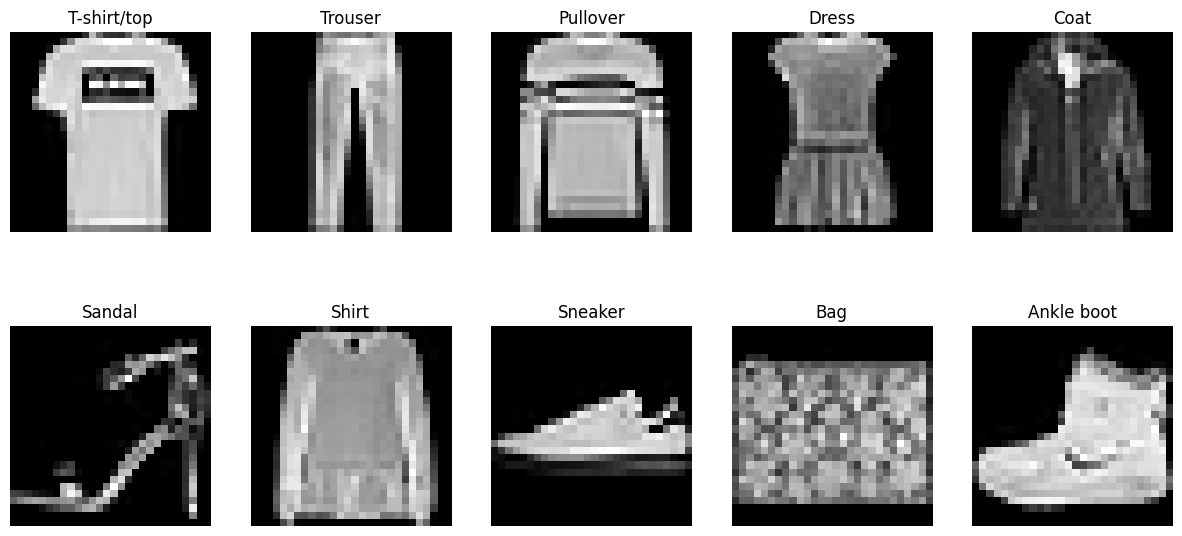

In [48]:
# Load the Fashion MNIST dataset
(train_images, train_lables), (test_images, test_lables) = fashion_mnist.load_data()

# Define class names corresponding to the 10 categories in the Fashion MNIST dataset
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]

#For each class potting one sample image
plt.figure(figsize=(15,7))

images_plot=[]
# Loop through each class label and plot the first image in the training set for that class
i=0
while i< len(class_names):
    # Discover the position of first occurence of class in dataset
    index = np.argmax(train_lables==i)

    # Ploting image for present class
    plt.subplot(2,5,i+1)  # No of rows=2 , No of colomns = 5 for 10 classes
    plt.imshow(train_images[index], cmap='gray')
    plt.title(class_names[i])  # Put the title to the class name
    plt.axis('off')  # Switch off the  axis lables for better visualization
    images_plot.append(wandb.Image(train_images[index], caption=class_names[i]))
    i+=1
wandb.log({'Question1':images_plot})

# Shows figure with plotted images
plt.show()
wandb.finish()

## NeuralNetwork

In [45]:
# import dataset
dataset = 'fashion_mnist'
if dataset == 'fashion_mnist':
  (x1, y1), (x2, y2) = fashion_mnist.load_data()
elif dataset== 'mnist':
  (x1, y1), (x2, y2) = mnist.load_data()

x1=x1.reshape(x1.shape[0],-1) / 255
x2=x2.reshape(x2.shape[0],-1)/ 255

x1, x_val, y1, y_val = train_test_split(x1,y1, test_size=0.1, random_state=0)

# defined Neuarl Network class
class NeuralNetwork:
    def __init__(self):

        self.w,self.b,self.a,self.h,self.wd,self.ad,self.hd,self.bd=[],[],[],[],[],[],[],[]


#Defines various activation functions
    def activations(self,act,k):
        if act=='sigmoid':
            s=1+np.exp(-k)
            return 1/s
        elif act =='ReLU':
            s=k*(k>0)
            return s
        elif act =='tanh':
            s = np.tanh(k)
            return s
        elif act == 'identity':
            return k
        elif act =='softmax':
            x=np.copy(k)
            i=0
            while i < k.shape[0]:
                add=0
                largi=np.argmax(k[i])
                j=0
                while j< k.shape[1]:
                    add+=np.exp(k[i][j]-k[i][largi])
                    j=j+1
                s=k[i]-k[i][largi]
                k[i]=np.exp(s)/add
                x[i]=k[i]
                i=i+1
            return x

# Defines derivatives of various activation functions.
    def activations_derivative(self,act,k):
        if act=='sigmoid':
            s = np.multiply((1/(1+np.exp(-k))),(1-(1/(1+np.exp(-k)))))
            return s
        if act=='ReLU':
            relu_derivative=0
            relu_derivative=np.maximum(0,k)
            relu_derivative[relu_derivative>0]=1
            return relu_derivative
        if act=='tanh':
            return 1-np.tanh(k)**2
        if act == 'identity':
            return 1


# Defines loss functions.
    def loss_function(self,fn_loss,yhat,y1,mom):
        cac=0
        i=0
        while i<len(self.w):
            s=np.sum(self.w[i]**2)
            cac=cac+s
            i=i+1
        cac=mom*cac
        cac=cac/2
        ch=1
        if fn_loss=='cross_entropy':
            loss=0
            i=0
            while i<y1.shape[0]:
                loss=loss-((np.log2(yhat[i][y1[i]])))
                i=i+1
            s=loss+cac
            z=y1.shape[0]
            return s/z

        elif fn_loss=='mean_squared_error':
            bl=np.zeros((y1.shape[0],yhat.shape[1]))
            i=0
            while i<y1.shape[0]:
                bl[i][y1[i]]=1
                i=i+1
            s=(np.sum(((yhat-bl)**2)))+cac
            t=y1.shape[0]
            return s/t


# Initializes weights and biases for the neural network layers.

    def make_layers(self,hidden_layers,neuron,neuron_input,start,classes,ques=0,hl=[]):

        self.w = []
        self.b = []

        all_layer=[]
        if ques == 0:
          np.random.seed(5)
          all_layer.append(neuron_input)
          i=0
          while i<hidden_layers:
              all_layer.append(neuron)
              i=i+1
          intialization = 0
          all_layer.append(classes)

        elif ques == 2:
          all_layer = [neuron_input] + hl + [classes]
          hidden_layers = len(hl)

        # all_layer = [784,128,,,,,10]
        if start=='random':
            i =0
            while i<= hidden_layers:
                # self.b.append(np.random.randn(1,all_layer[i+1]))
                # self.w.append(np.random.randn(all_layer[i],all_layer[i+1]))

                self.b.append(np.random.uniform(-0.5,0.5,(1,all_layer[i+1])))
                self.w.append(np.random.uniform(-0.5,0.5,(all_layer[i],all_layer[i+1])))
                i=i+1
        if start=='Xavier':
            i=0
            while i<= hidden_layers:
                self.b.append((np.random.randn(1,all_layer[i+1]))*np.sqrt(6/(1+all_layer[i+1])))
                self.w.append((np.random.randn(all_layer[i],all_layer[i+1]))*np.sqrt(6/(all_layer[i]+all_layer[i+1])))

                # n=np.sqrt(6/(all_layer[i]+all_layer[i+1]))
                # wt=np.random.uniform(-n,n,(all_layer[i],all_layer[i+1]))
                # b=np.random.uniform(-n,n,(1,all_layer[i+1]))
                # self.b.append(b)
                # self.w.append(wt)
                i=i+1

#Performs forward pass through the neural network layers.
    def forward_pass(self,x,act='sigmoid'):

        self.a,self.h=[],[]
        check=x
        i=0
        while i<len(self.w)-1:
            q1=np.add(np.matmul(check,self.w[i]),self.b[i])
            bool = act=='ReLU' and i==0
            if (bool):
                j=0
                s=q1.shape[0]
                while j < s:
                    maxi=np.argmax(q1[j])
                    q1[j]/=q1[j][maxi]
                    j=j+1
            r1=self.activations(act,q1)
            check=r1
            self.h.append(r1)
            self.a.append(q1)
            i=i+1
        # print(len(self.w)-1,"check")
        z=len(self.w)-1
        q1=np.add(np.matmul(check,self.w[z]),self.b[z])
        r1=self.activations('softmax',q1)
        self.h.append(r1)
        self.a.append(q1)

        return self.h[-1]


# Performs backward pass through the neural network layers to compute gradients.
    def backward_pass(self,yhat,y1,x1,classes,activation,fn_loss,mom):
        self.wd,self.bd,self.ad,self.hd=[],[],[],[]
        bl=0
        bl=np.zeros((y1.shape[0],classes))
        i=0
        while i< y1.shape[0]:
            bl[i][y1[i]]=1
            i=i+1

        b=None
        a=None


        if fn_loss=="cross_entropy":
            yhatl=np.zeros((yhat.shape[0],1))
            i=0
            while i< yhat.shape[0]:
                yhatl[i]=yhat[i][y1[i]]
                i=i+1

            b=-1*(bl-yhat)
            a=-1*(bl/yhatl)

            self.hd.append(a)
            self.ad.append(b)

        elif fn_loss=="mean_squared_error":
            s=yhat-bl
            a=2*s
            self.hd.append(a)
            b=[]
            j=0
            while j< yhat.shape[1]:
                r=yhat.shape[0]
                s=yhat.shape[1]
                hot_j=np.zeros((r,s))
                hot_j[:,j]=1
                hat_j=np.ones((r,s))*(yhat[:,j].reshape(r,1))
                l=yhat-bl
                x=hot_j-hat_j
                aj=2*(np.sum((l)*(yhat*(x)),axis=1))
                b.append(aj)
                j=j+1
            self.ad.append(np.array(b).T)



        j = len(self.w)-1
        while j>-1:
            u=self.h[j-1].T
            bool = (j==0)
            if bool:
                u=x1.T
            t=x1.shape[0]
            length=len(self.ad)
            w=np.matmul(u,self.ad[-1])/t
            b=np.sum(self.ad[length-1],axis=0)/t
            if j!=0:
                a=np.matmul(self.ad[length-1],self.w[j].T)
                der=self.activations_derivative(activation,self.a[j-1])
                z=np.multiply(a,der)
                self.hd.append(a)
                self.ad.append(z)
            self.bd.append(b)
            self.wd.append(w)
            j=j-1
        i=0

        while i< len(self.w):
            s=len(self.w)-1-i
            self.wd[s]-=mom*self.w[i]
            i=i+1
#Compute the accuracy of the neural network on the given dataset.
    def accuracy(self,x2,y2,act):
        self.forward_pass(x2,act)
        ypred=np.argmax(self.h[len(self.w)-1],axis=1)
        n=0
        l=y2.shape[0]
        i=0
        while i<y2.shape[0]:
            if ypred[i]!=y2[i]:
                n+=+1
            i+=1
        return ((x2.shape[0]-n)/y2.shape[0])*100

#Make predictions using the neural network and print the test accuracy.
    def predict(self,x2,y2,act):
        self.forward_pass(x2,act)
        fut=np.argmax(self.h[len(self.w)-1],axis=1)
        n=0
        i=0
        while i < y2.shape[0]:
            if fut[i]!=y2[i]:
                n+=1
            i+=1

        acc=((x2.shape[0]-n)/y2.shape[0])*100
        print("Test Accuracy: "+str(acc))

#Create batches from input data and labels.
    def createBatches(self,x1,y1,size):
        info,res=[],[]
        s=x1.shape[0]
        l=math.ceil(s/size)
        i=0
        while i < l:
            group,group_ans=[],[]
            j=i*size
            s=min((i+1)*size,x1.shape[0])
            while j< s:
                group.append(x1[j])
                group_ans.append(y1[j])
                j+=1
            group_ans=np.array(group_ans)
            group=np.array(group)
            info.append(group)
            res.append(group_ans)
            i+=1
        return info,res

#Perform one pass of forward and backward propagation through the network.
    def onePass(self,x1,y1,classes,lay,rate,act,fn_loss,mom):
        self.forward_pass(x1 ,act)
        l=lay-1
        self.backward_pass(self.h[l], y1,x1,10, act,fn_loss,mom)

# Train the neural network using sgd.
    def sgd(self,x1,y1,lay,epo,count,size,act,fn_ans,mom,c_l,w_l):
        classes=10
        info,res=self.createBatches(x1,y1,size)

        i=0
        while i < epo:
            h=None
            j=0
            s=len(info)
            while j< s:
                self.onePass(info[j],res[j],classes,lay,count,act,fn_ans,mom)
                k=0
                while k< lay:
                    q=lay-1-k
                    self.w[k]-=count*(self.wd[q])
                    self.b[k]-=count*self.bd[q]
                    k+=1
                j+=1
            i+=1
            self.forward_pass(x1,act)
            loss_train=1
            loss1=self.loss_function(fn_ans,self.h[lay-1],y1,mom)
            self.forward_pass(x_val,act)
            loss2=self.loss_function(fn_ans,self.h[lay-1],y_val,mom)
            acc1=self.accuracy(x1,y1,act)
            acc2=self.accuracy(x_val,y_val,act)

            if w_l == 1:
              wandb.log(
                      {
                          'epoch': i,
                          'training_loss' : round(loss1,2),
                          'training_accuracy' : round(acc1,2),
                          'validation_loss' : round(loss2,2),
                          'validation_accuracy':round(acc2,2)
                      }
                  )
            if c_l == 1:

              print("Iteration Number: "+str(i), end="")
              print(" Train Loss : "+str(loss1))
              print("Iteration Number: "+str(i), end="")
              print(" Validation Loss : "+str(loss2))
              print("Iteration Number: "+str(i), end="")
              print(" Train Accurcy : "+str(acc1))
              print("Iteration Number: "+str(i), end="")
              print(" Validaion Accuracy: "+str(acc2))

# Train the neural network using momentum
    def momentum(self,x1,y1,lay,epo,count,size,eta,act,fn_loss,mom,c_l,w_l):
        info,res=self.createBatches(x1,y1,size)
        classes=10
        alpha,beta=[],[]
        i=0
        while i< lay:
            a=np.zeros((self.w[i].shape))
            b=np.zeros(self.b[i].shape)
            beta.append(b)
            alpha.append(a)
            i+=1
        i=0
        while i<epo :
            j=0
            while j< len(info):
                self.onePass(info[j],res[j],classes,lay,count,act,fn_loss,mom)
                k=0
                while k < lay:
                    s=lay-1-k
                    alpha[k]=(alpha[k]*eta)+self.wd[s]
                    beta[k]=(beta[k]*eta)+self.bd[s]
                    self.w[k]-=count*alpha[k]
                    self.b[k]-=count*beta[k]
                    k+=1
                j+=1
            i+=1

            self.forward_pass(x1,act)
            loss1=self.loss_function(fn_loss,self.h[lay-1],y1,mom)
            self.forward_pass(x_val,act)
            loss2=self.loss_function(fn_loss,self.h[lay-1],y_val,mom)
            acc1=self.accuracy(x1,y1,act)
            acc2=self.accuracy(x_val,y_val,act)

            if w_l == 1:
              wandb.log(
                      {
                          'epoch': i,
                          'training_loss' : round(loss1,2),
                          'training_accuracy' : round(acc1,2),
                          'validation_loss' : round(loss2,2),
                          'validation_accuracy':round(acc2,2)
                      }
                  )
            if c_l == 1:

              print("Iteration Number: "+str(i), end="")
              print(" Train Loss : "+str(loss1))
              print("Iteration Number: "+str(i), end="")
              print(" Validation Loss : "+str(loss2))
              print("Iteration Number: "+str(i), end="")
              print(" Train Accurcy : "+str(acc1))
              print("Iteration Number: "+str(i), end="")
              print(" Validaion Accuracy: "+str(acc2))

# Train the neural network using nestrov
    def nag(self,x1,y1,lay,epo,count,size,eta,act,fn_loss,mom,c_l,w_l):
        classes=10
        info,res=self.createBatches(x1,y1,size)

        alpha,beta=[],[]

        i=0
        while i<lay:
            b=np.zeros((self.b[i].shape))
            a=np.zeros((self.w[i].shape))
            beta.append(b)
            alpha.append(a)
            i+=1

        i=0
        while i< epo:
            j=0
            while j< len(info):
                k=0
                while k < lay:
                    self.b[k]-=eta*beta[k]
                    self.w[k]-=eta*alpha[k]
                    k+=1
                self.onePass(info[j],res[j],classes,lay,count,act,fn_loss,mom)
                k=0
                while k<lay:
                    s=lay-1-k
                    alpha[k]=(eta*alpha[k])+count*(self.wd[s])
                    beta[k]=(eta*beta[k])+count*self.bd[s]
                    self.b[k]-=beta[k]
                    self.w[k]-=alpha[k]
                    k+=1
                j+=1
            i+=1

            self.forward_pass(x1,act)
            s=lay-1
            loss1=self.loss_function(fn_loss,self.h[s],y1,mom)
            self.forward_pass(x_val,act)
            loss2=self.loss_function(fn_loss,self.h[s],y_val,mom)
            acc1=self.accuracy(x1,y1,act)
            acc2=self.accuracy(x_val,y_val,act)
            if w_l == 1:
              wandb.log(
                      {
                          'epoch': i,
                          'training_loss' : round(loss1,2),
                          'training_accuracy' : round(acc1,2),
                          'validation_loss' : round(loss2,2),
                          'validation_accuracy':round(acc2,2)
                      }
                  )
            if c_l == 1:

              print("Iteration Number: "+str(i), end="")
              print(" Train Loss : "+str(loss1))
              print("Iteration Number: "+str(i), end="")
              print(" Validation Loss : "+str(loss2))
              print("Iteration Number: "+str(i), end="")
              print(" Train Accurcy : "+str(acc1))
              print("Iteration Number: "+str(i), end="")
              print(" Validaion Accuracy: "+str(acc2))



# Train the neural network using rmsProp.
    def rmsprop(self,x1,y1,lay,epo,count,size,eta,act,fn_loss,mom,e,c_l,w_l):
        info,res=self.createBatches(x1,y1,size)
        classes =10
        alpha,beta=[],[]

        i=0
        while i< lay:
            b=np.zeros((self.b[i].shape))
            a=np.zeros((self.w[i].shape))
            beta.append(b)
            alpha.append(a)
            i+=1

        i=0
        while i < int(epo):
            j=0
            while j < len(info):
                self.onePass(info[j],res[j],classes,lay,count,act,fn_loss,mom)
                k=0
                while k < lay:
                    s=lay-1-k
                    q=1-eta
                    alpha[k]=(alpha[k]*eta)+(q)*np.square(self.wd[s])
                    beta[k]=(beta[k]*eta)+(q)*np.square(self.bd[s])
                    self.w[k]-=(count/np.sqrt(np.linalg.norm(alpha[k]+e)))*self.wd[s]
                    self.b[k]-=(count/np.sqrt(np.linalg.norm(beta[k]+e)))*self.bd[s]
                    k+=1
                j+=1
            i+=1

            self.forward_pass(x1,act)
            s=lay-1
            loss1=self.loss_function(fn_loss,self.h[s],y1,mom)
            self.forward_pass(x_val,act)
            loss2=self.loss_function(fn_loss,self.h[s],y_val,mom)
            acc1=self.accuracy(x1,y1,act)
            acc2=self.accuracy(x_val,y_val,act)
            if w_l == 1:
              wandb.log(
                      {
                          'epoch': i,
                          'training_loss' : round(loss1,2),
                          'training_accuracy' : round(acc1,2),
                          'validation_loss' : round(loss2,2),
                          'validation_accuracy':round(acc2,2)
                      }
                  )
            if c_l == 1:

              print("Iteration Number: "+str(i), end="")
              print(" Train Loss : "+str(loss1))
              print("Iteration Number: "+str(i), end="")
              print(" Validation Loss : "+str(loss2))
              print("Iteration Number: "+str(i), end="")
              print(" Train Accurcy : "+str(acc1))
              print("Iteration Number: "+str(i), end="")
              print(" Validaion Accuracy: "+str(acc2))

# Train the neural network using adam.
    def adam(self,x1,y1,lay,epo,count,size,eta1,eta2,act,fn_loss,e,mom,c_l,w_l):
        info,res=self.createBatches(x1,y1,size)
        classes=10
        w1,w2,b1,b2=[],[],[],[]

        i=0
        while i< lay:
            b=np.zeros((self.w[i].shape))
            a=np.zeros((self.w[i].shape))
            w2.append(b)
            w1.append(a)
            b=np.zeros((self.b[i].shape))
            a=np.zeros((self.b[i].shape))
            b1.append(a)
            b2.append(b)
            i+=1

        a=0
        i = 0
        while i < int(epo):
            j=0
            while j< len(info):
                a=a+1
                self.onePass(info[j],res[j],classes,lay,count,act,fn_loss,mom)
                k=0
                while k< lay:
                    r=1-eta1
                    p=1-eta2
                    u=1-eta1**a
                    v=1-eta2**a
                    s=lay-1-k

                    w1[k]=(w1[k]*eta1)+(r)*self.wd[s]
                    mwhat=w1[k]/(u)

                    w2[k]=(w2[k]*eta2)+(p)*np.square(self.wd[s])
                    vwhat=w2[k]/(v)

                    b1[k]=(b1[k]*eta1)+(r)*self.bd[s]
                    mbhat=b1[k]/(u)

                    b2[k]=(b2[k]*eta2)+(p)*np.square(self.bd[s])
                    vbhat=b2[k]/(v)

                    self.w[k]-=(count/np.sqrt(vwhat+e))*mwhat
                    self.b[k]-=(count/np.sqrt(vbhat+e))*mbhat
                    k+=1
                j+=1
            i=i+1
            self.forward_pass(x1, act)
            s=lay-1
            loss1=self.loss_function(fn_loss,self.h[s],y1,mom)
            self.forward_pass(x_val,act)
            loss2=self.loss_function(fn_loss,self.h[s],y_val,mom)
            acc1=self.accuracy(x1,y1,act)
            acc2=self.accuracy(x_val,y_val,act)
            if w_l == 1:
              wandb.log(
                      {
                          'epoch': i,
                          'training_loss' : round(loss1,2),
                          'training_accuracy' : round(acc1,2),
                          'validation_loss' : round(loss2,2),
                          'validation_accuracy':round(acc2,2)
                      }
                  )
            if c_l == 1:

              print("Iteration Number: "+str(i), end="")
              print(" Train Loss : "+str(loss1))
              print("Iteration Number: "+str(i), end="")
              print(" Validation Loss : "+str(loss2))
              print("Iteration Number: "+str(i), end="")
              print(" Train Accurcy : "+str(acc1))
              print("Iteration Number: "+str(i), end="")
              print(" Validaion Accuracy: "+str(acc2))

# Train the neural network using Nadam
    def nadam(self,x1,y1,lay,epo,count,size,eta1,eta2,act,fn_loss,e,mom,c_l,w_l):
        classes=10
        w1,w2,b1,b2=[],[],[],[]
        info,res=self.createBatches(x1,y1,size)

        for i in range(lay):
            b=np.zeros((self.w[i].shape))
            a=np.zeros((self.w[i].shape))
            w2.append(b)
            w1.append(a)
            b=np.zeros((self.b[i].shape))
            a=np.zeros((self.b[i].shape))
            b1.append(a)
            b2.append(b)

        a=0
        i=0
        while i< int(epo):
            j=0
            while j< len(info):
                a=a+1
                self.onePass(info[j],res[j],classes,lay,count,act,fn_loss,mom)
                k=0
                while k < lay:
                    r=1-eta1
                    p=1-eta2
                    u=1-eta1**a
                    v=1-eta2**a
                    s=lay-1-k
                    w1[k]=(w1[k]*eta1)+(r)*self.wd[s]
                    mwhat=w1[k]/(u)

                    w2[k]=(w2[k]*eta2)+(p)*np.square(self.wd[s])
                    vwhat=w2[k]/(v)

                    b1[k]=(b1[k]*eta1)+(r)*self.bd[s]
                    mbhat=b1[k]/(u)

                    b2[k]=(b2[k]*eta2)+(p)*np.square(self.bd[s])
                    vbhat=b2[k]/(v)

                    self.w[k]-=(count/np.sqrt(vwhat+e))*(eta1*mwhat+(((r)*self.wd[s])/(u)))
                    self.b[k]-=(count/np.sqrt(vbhat+e))*(eta1*mbhat+(((r)*self.bd[s])/(u)))
                    k=k+1
                j=j+1
            i=i+1
            self.forward_pass(x1,act)
            s=lay-1
            loss1=self.loss_function(fn_loss ,self.h[s],y1,mom)
            self.forward_pass(x_val ,act)
            loss2=self.loss_function(fn_loss,self.h[s], y_val,mom)
            acc1=self.accuracy(x1 ,y1 ,act)
            acc2=self.accuracy(x_val ,y_val,act)
            if w_l == 1:
              wandb.log(
                      {
                          'epoch': i,
                          'training_loss' : round(loss1,2),
                          'training_accuracy' : round(acc1,2),
                          'validation_loss' : round(loss2,2),
                          'validation_accuracy':round(acc2,2)
                      }
                  )
            if c_l == 1:

              print("Iteration Number: "+str(i), end="")
              print(" Train Loss : "+str(loss1))
              print("Iteration Number: "+str(i), end="")
              print(" Validation Loss : "+str(loss2))
              print("Iteration Number: "+str(i), end="")
              print(" Train Accurcy : "+str(acc1))
              print("Iteration Number: "+str(i), end="")
              print(" Validaion Accuracy: "+str(acc2))


# training the model based one given parameters
    def fit_model(self,x1,y1,x2,y2,hiddenlayers,neuron,input_neuron,batch,initialization,fn_loss,activation,optimizer,n,iter,beta,beta1,beta2,e,alpha,mom,c_l=1,w_l=1):
        # self.w,self.b=[],[]
        self.make_layers(hiddenlayers,neuron,input_neuron,initialization,10)
        # print(len(self.w),"arch")
        if optimizer=="sgd":
            self.sgd(x1,y1,len(self.w),iter,n,batch,activation,fn_loss,alpha,c_l,w_l)
        elif optimizer=='momentum':
            self.momentum(x1,y1,len(self.w),iter,n,batch,mom,activation,fn_loss,alpha,c_l,w_l)
        elif optimizer=='nag':
            self.nag(x1,y1,len(self.w),iter,n,batch,beta,activation,fn_loss,alpha,c_l,w_l)
        elif optimizer=='rmsprop':
            self.rmsprop(x1,y1,len(self.w),iter,n,batch,beta,activation,fn_loss,alpha,e,c_l,w_l)
        elif optimizer=='adam':
            self.adam(x1,y1,len(self.w),iter,n,batch,beta1,beta2,activation,fn_loss,e,alpha,c_l,w_l)
        elif optimizer=='nadam':
            self.nadam(x1,y1,len(self.w),iter,n,batch,beta1,beta2,activation,fn_loss,e,alpha,c_l,w_l)




## Ques :2

In [44]:
# Implementing forward pass
# Also making it flexible so that hidden layer size can vert
obj = NeuralNetwork()
hiddenlayer = [16,32,64]
obj.make_layers(4,64,784,'Xavier',10,2,hiddenlayer)
y_preds = obj.forward_pass(x2[1],act='tanh')
print("predicted values ->",y_preds)


predicted values -> [[0.01443834 0.07875069 0.01137712 0.65987786 0.08924478 0.08503693
  0.00376674 0.00591696 0.0200263  0.03156428]]


## Ques : 3

In [46]:
wandb.init(project="DL-Assignment-1")
obj=NeuralNetwork()
obj.fit_model(x1,
                 y1,
                 x_val,
                 y_val,
                 hiddenlayers=3,
                 neuron=128,
                 input_neuron=784,
                 batch=32,
                 initialization="Xavier",
                 fn_loss="cross_entropy",
                 activation="tanh",
                 optimizer="rmsprop",
                 n=0.001,
                 iter=3,
                 beta=0.9,
                 beta1=0.999,
                 beta2=0.999,
                 e=1e-8,
                 alpha=0,
                 mom=0.9)
obj.predict(x2,y2,act="tanh")
wandb.finish()

epoch,▁
training_accuracy,▁
training_loss,▁
validation_accuracy,▁
validation_loss,▁
epoch,1
training_accuracy,84.6
training_loss,0.61
validation_accuracy,83.97
validation_loss,0.63


Iteration Number: 1 Train Loss : 0.7012754208174107
Iteration Number: 1 Validation Loss : 0.7167375521812134
Iteration Number: 1 Train Accurcy : 82.53703703703704
Iteration Number: 1 Validaion Accuracy: 82.26666666666667
Iteration Number: 2 Train Loss : 0.6132405642489823
Iteration Number: 2 Validation Loss : 0.6291092219709723
Iteration Number: 2 Train Accurcy : 84.77222222222223
Iteration Number: 2 Validaion Accuracy: 84.21666666666667
Iteration Number: 3 Train Loss : 0.567798257545084
Iteration Number: 3 Validation Loss : 0.5862449159432226
Iteration Number: 3 Train Accurcy : 85.87407407407407
Iteration Number: 3 Validaion Accuracy: 85.51666666666667
Test Accuracy: 84.28


epoch,▁▅█
training_accuracy,▁▆█
training_loss,█▃▁
validation_accuracy,▁▅█
validation_loss,█▃▁
epoch,3
training_accuracy,85.87
training_loss,0.57
validation_accuracy,85.52
validation_loss,0.59


## Ques 4

In [ ]:
sweep_config = {
            'name': 'sweep 1 : random',
            'method': 'random',
            'metric': { 'goal': 'maximize','name': 'Accuracy'},
            'parameters':
                {
                    # 'dataset' : {'values': ['fashion_mnist']}, # 'fashion_mnist', 'mnist'
                    'iter': {'values': [5,10]},
                    'batch': {'values': [32,64]},
                    'fn_loss': {'values': ['cross_entropy', 'mean_squared_error']}, # 'mean_squared_error', 'cross_entropy'
                    'optimizer': {'values': ['sgd', 'momentum', 'nag', 'rmsprop', 'adam', 'nadam']}, # 'sgd', 'momentum', 'nag', 'rmsprop', 'adam', 'nadam'
                    'n' : {'values': [1e-3, 1e-4]},
                    'mom' : {'values': [0.9,0.5]},
                    'beta' : {'values': [0.9,0.5]},
                    'beta1' : {'values': [0.999]},
                    'beta2' : {'values': [0.999]},
                    'e' : {'values': [1e-6]},
                    'alpha': {'values': [0,0.0005]},
                    'initialization': {'values': ['random','Xavier']}, # 'random', 'Xavier'
                    'hiddenlayers': {'values': [3, 4, 5]},
                    'neuron': {'values': [32, 64, 128]},
                    'activation': {'values': ['identity', 'sigmoid','tanh', 'ReLU']}, # 'identity', 'sigmoid', 'tanh', 'ReLU'
                    'outAct': {'values': ['softmax']}
                }
            }



def train():
    #init-classinit , config - param_copy
    init = wandb.init(project='DL-Assignment-1')
    config = init.config
    wandb.run.name = (
        'o:' + config.optimizer +
        '_a:' + config.activation +
        '_ep:' + str(config.iter) +
        '_l:' + config.fn_loss +
        '_i:' + config.initialization +
        '_hl:' + str(config.hiddenlayers) +
        '_hls:' + str(config.neuron)
    )
    obj=NeuralNetwork()
    obj.fit_model(x1,
                    y1,
                    x_val,
                    y_val,
                    hiddenlayers=config.hiddenlayers,
                    neuron=config.neuron,
                    input_neuron=784,
                    batch=config.batch,
                    initialization=config.initialization,
                    fn_loss=config.fn_loss,
                    activation=config.activation,
                    optimizer=config.optimizer,
                    n=config.n,
                    iter=config.iter,
                    beta=config.beta,
                    beta1=config.beta1,
                    beta2=config.beta2,
                    e=config.e,
                    alpha=config.alpha,
                    mom=config.mom)

    val_acc = obj.accuracy(x_val,y_val,config.activation)
    wandb.log({'Accuracy': val_acc})




sweep_id = wandb.sweep(sweep_config, project='DL-Assignment-1')
wandb.agent(sweep_id, train, count = 300)
wandb.finish()





## Ques 7

In [37]:
wandb.init(project='DL-Assignment-1')
obj=NeuralNetwork()
obj.fit_model(x1,
                 y1,
                 x_val,
                 y_val,
                 hiddenlayers=4,
                 neuron=128,
                 input_neuron=784,
                 batch=32,
                 initialization="Xavier",
                 fn_loss="cross_entropy",
                 activation="tanh",
                 optimizer="nadam",
                 n=0.0005,
                 iter=1,
                 beta=0.9,
                 beta1=0.999,
                 beta2=0.999,
                 e=1e-8,
                 alpha=0,
                 mom=0.9)





Iteration Number: 1 Train Loss : 0.5637975557781287
Iteration Number: 1 Validation Loss : 0.5722831418591378
Iteration Number: 1 Train Accurcy : 85.56851851851852
Iteration Number: 1 Validaion Accuracy: 85.51666666666667


In [38]:
wandb.init(project="DL-Assignment-1", name="Ques 7")
true_label = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
y_preds=[]
for i in range (len(x2)):
  y_preds.append(obj.forward_pass(x2[i],act='tanh'))


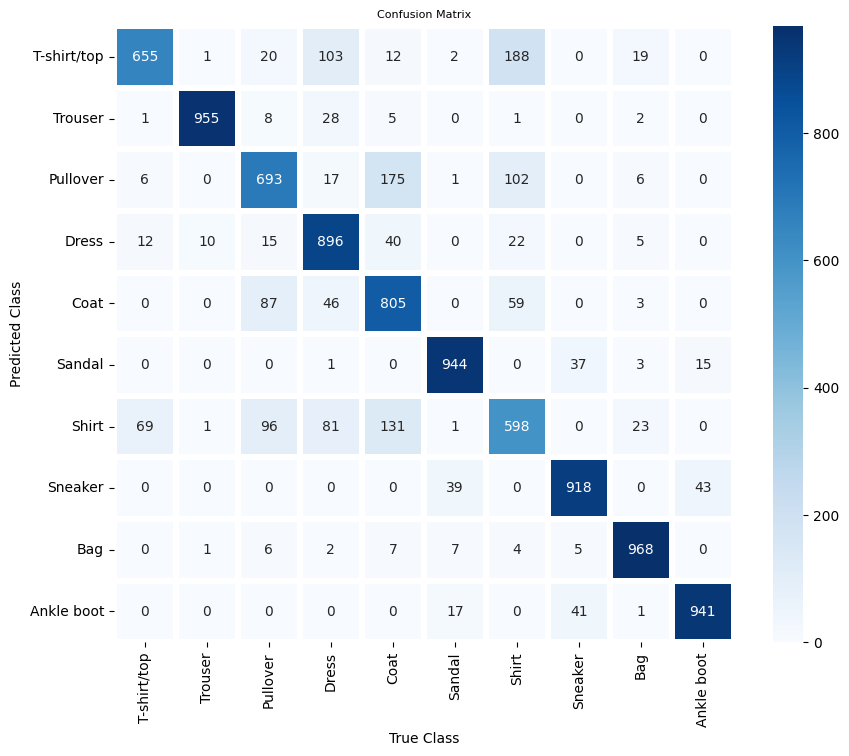

epoch,▁
training_accuracy,▁
training_loss,▁
validation_accuracy,▁
validation_loss,▁
epoch,1
training_accuracy,85.57
training_loss,0.56
validation_accuracy,85.52
validation_loss,0.57


In [39]:
# Run Neural Network class before plotting confusion matrix
y2 = np.eye(10)[y2]
mat = pd.DataFrame(confusion_matrix(np.argmax(y2,1) , np.argmax(np.array(y_preds).squeeze(),1)))
plt.figure(figsize=(10, 8))

axis = seaborn.heatmap(mat, annot=True,cmap='Blues',fmt='d',linewidths=3,linecolor='white')
axis.set_xticklabels(true_label,rotation=90)
axis.set_yticklabels(true_label,rotation=0)

plt.title('Confusion Matrix', fontsize=8)
plt.ylabel("Predicted Class")
plt.xlabel("True Class")

wandb.log({"Confusion_Matrix": wandb.Image(plt)})

plt.show()
wandb.finish()

## Ques 8

In [ ]:
sweep_config = {
            'name': 'sweep 2 : ce vs mse',
            'method': 'grid',
            'metric': { 'goal': 'maximize','name': 'Accuracy'},
            'parameters':
                {
                    # 'dataset' : {'values': ['fashion_mnist']}, # 'fashion_mnist', 'mnist'
                    'iter': {'values': [10]},
                    'batch': {'values': [64]},
                    'fn_loss': {'values': ['cross_entropy', 'mean_squared_error']}, # 'mean_squared_error', 'cross_entropy'
                    'optimizer': {'values': ['sgd', 'momentum', 'nag', 'rmsprop', 'adam', 'nadam']}, # 'sgd', 'momentum', 'nag', 'rmsprop', 'adam', 'nadam'
                    'n' : {'values': [1e-3, 1e-4]},
                    'mom' : {'values': [0.9]},
                    'beta' : {'values': [0.9]},
                    'beta1' : {'values': [0.999]},
                    'beta2' : {'values': [0.999]},
                    'e' : {'values': [1e-6]},
                    'alpha': {'values': [0]},
                    'initialization': {'values': ['Xavier']}, # 'random', 'Xavier'
                    'hiddenlayers': {'values': [4, 5]},
                    'neuron': {'values': [32, 64]},
                    'activation': {'values': ['tanh', 'ReLU']}, # 'identity', 'sigmoid', 'tanh', 'ReLU'
                    'outAct': {'values': ['softmax']}
                }
            }



def train():
    #init-classinit , config - param_copy
    init = wandb.init(project='DL-Assignment-1')
    config = init.config
    wandb.run.name = (
        'o:' + config.optimizer +
        '_a:' + config.activation +
        '_ep:' + str(config.iter) +
        '_l:' + config.fn_loss +
        '_i:' + config.initialization +
        '_hl:' + str(config.hiddenlayers) +
        '_hls:' + str(config.neuron)
    )
    obj=NeuralNetwork()
    obj.fit_model(x1,
                    y1,
                    x_val,
                    y_val,
                    hiddenlayers=config.hiddenlayers,
                    neuron=config.neuron,
                    input_neuron=784,
                    batch=config.batch,
                    initialization=config.initialization,
                    fn_loss=config.fn_loss,
                    activation=config.activation,
                    optimizer=config.optimizer,
                    n=config.n,
                    iter=config.iter,
                    beta=config.beta,
                    beta1=config.beta1,
                    beta2=config.beta2,
                    e=config.e,
                    alpha=config.alpha,
                    mom=config.mom)

    val_acc = obj.accuracy(x_val,y_val,config.activation)
    wandb.log({'Accuracy': val_acc})




sweep_id = wandb.sweep(sweep_config, project='DL-Assignment-1')
wandb.agent(sweep_id, train, count = 300)
wandb.finish()





## Ques 10

In [ ]:
(x1, y1), (x2, y2) = mnist.load_data()

x1=x1.reshape(x1.shape[0],-1) / 255
x2=x2.reshape(x2.shape[0],-1)/ 255

x1, x_val, y1, y_val = train_test_split(x1,y1, test_size=0.1, random_state=0)

11490434/11490434 [==============================] - 0s 0us/step


### Model :1

In [ ]:

obj=NeuralNetwork()
obj.fit_model(x1,
                 y1,
                 x_val,
                 y_val,
                 hiddenlayers=4,
                 neuron=128,
                 input_neuron=784,
                 batch=64,
                 initialization="Xavier",
                 fn_loss="cross_entropy",
                 activation="tanh", # tanh relu
                 optimizer="nadam", # N,A,Rms
                 n=0.0001,
                 iter=10,
                 beta=0.9,
                 beta1=0.999,
                 beta2=0.999,
                 e=1e-6,
                 alpha=0,
                 mom=0.9)

## Model:2

In [ ]:

obj=NeuralNetwork()
obj.fit_model(x1,
                 y1,
                 x_val,
                 y_val,
                 hiddenlayers=4,
                 neuron=128,
                 input_neuron=784,
                 batch=32,
                 initialization="Xavier",
                 fn_loss="cross_entropy",
                 activation="ReLU",
                 optimizer="nadam",
                 n=0.0001,
                 iter=10,
                 beta=0.9,
                 beta1=0.999,
                 beta2=0.999,
                 e=1e-6,
                 alpha=0,
                 mom=0.9)

## Model: 3

In [ ]:

obj=NeuralNetwork()
obj.fit_model(x1,
                 y1,
                 x_val,
                 y_val,
                 hiddenlayers=4,
                 neuron=128,
                 input_neuron=784,
                 batch=64,
                 initialization="Xavier",
                 fn_loss="cross_entropy",
                 activation="tanh", # tanh relu
                 optimizer="adam", # N,A,Rms
                 n=0.0001,
                 iter=10,
                 beta=0.9,
                 beta1=0.999,
                 beta2=0.999,
                 e=1e-6,
                 alpha=0,
                 mom=0.9)